# Model Selection and Assessment

Outline of the session:

- Model performance evaluation and **detection of overfitting with Cross-Validation**
- **Hyper parameter tuning** and model selection with Grid Search
- Error analysis with **learning curves** and the **Bias-Variance trade-off**
- Overfitting via Model Selection and the **Development / Evaluation set split**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

## The Hand Written Digits Dataset

Let's load a simple dataset of 8x8 gray level images of handwritten digits (bundled in the sklearn source code):

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
list(digits.keys())

['images', 'data', 'target_names', 'DESCR', 'target']

In [3]:
print(digits.DESCR)

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

In [4]:
X, y = digits.data, digits.target

print("data shape: %r, target shape: %r" % (X.shape, y.shape))
print("classes: %r" % list(np.unique(y)))

data shape: (1797, 64), target shape: (1797,)
classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [5]:
n_samples, n_features = X.shape
print("n_samples=%d" % n_samples)
print("n_features=%d" % n_features)

n_samples=1797
n_features=64


In [6]:
def plot_gallery(data, labels, shape, interpolation='nearest'):
    for i in range(data.shape[0]):
        plt.subplot(1, data.shape[0], (i + 1))
        plt.imshow(data[i].reshape(shape), interpolation=interpolation)
        plt.title(labels[i])
        plt.xticks(()), plt.yticks(())

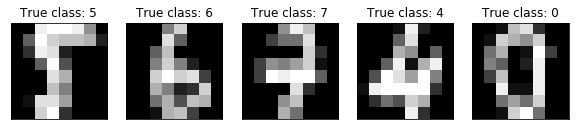

In [7]:
subsample = np.random.permutation(X.shape[0])[:5]
images = X[subsample]
labels = ['True class: %d' % l for l in y[subsample]]
plot_gallery(images, labels, shape=(8, 8))

Let's visualize the dataset on a 2D plane using a projection on the first 2 axis extracted by Principal Component Analysis:

In [8]:
from sklearn.decomposition import RandomizedPCA

pca = RandomizedPCA(n_components=2)
X_pca = pca.fit_transform(X)

X_pca.shape

/anaconda/envs/python2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


(1797, 2)

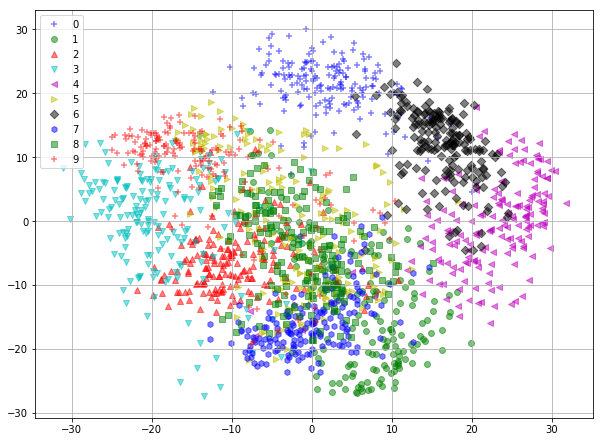

In [9]:
from itertools import cycle

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
markers = ['+', 'o', '^', 'v', '<', '>', 'D', 'h', 's']
for i, c, m in zip(np.unique(y), cycle(colors), cycle(markers)):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1],
        c=c, marker=m, label=i, alpha=0.5)
    
_ = plt.legend(loc='best')

We can observe that even in 2D, the groups of digits are quite well separated, especially the digit "0" that is very different from any other (the closest being "6" as it often share most the left hand side pixels). We can also observe that at least in 2D, there is quite a bit of overlap between the "1", "2" and "7" digits.

To better understand the meaning of the "x" and "y" axes of this plot it is also visualize the values of the first two principal components that are used to compute this projection:

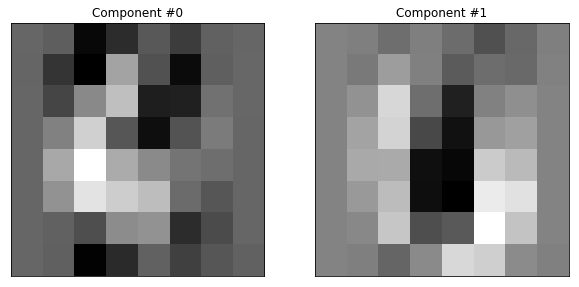

In [10]:
labels = ['Component #%d' % i for i in range(len(pca.components_))]
plot_gallery(pca.components_, labels, shape=(8, 8))

Has this dataset is small, both in terms of number of samples (1797) and features (64), we can compute the full (untruncated), exact PCA and have a look at the percentage of variance explained by each component of the PCA model:

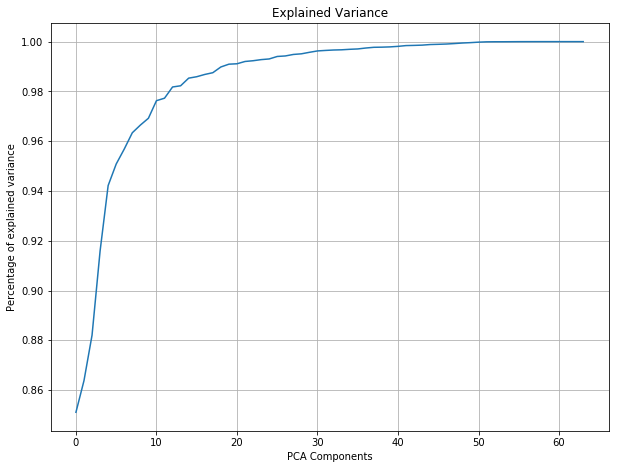

In [11]:
from sklearn.decomposition import PCA

pca_big = PCA().fit(X, y)
plt.title("Explained Variance")
plt.ylabel("Percentage of explained variance")
plt.xlabel("PCA Components")
plt.plot(1-pca_big.explained_variance_ratio_);

It might be easier to interpret by plotting the cumulated variance by previous components by using the `numpy.cumsum` function:

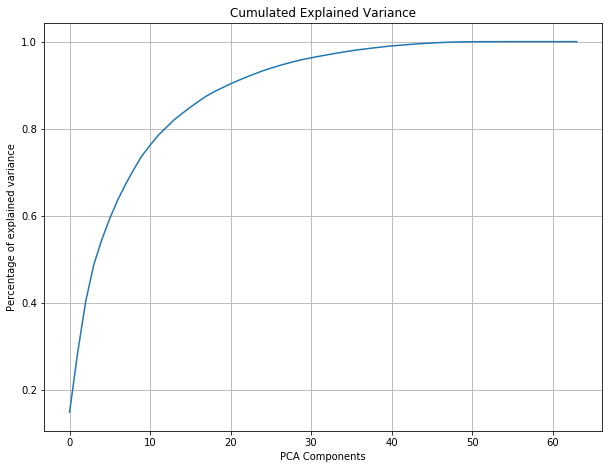

In [12]:
plt.title("Cumulated Explained Variance")
plt.ylabel("Percentage of explained variance")
plt.xlabel("PCA Components")
plt.plot(np.cumsum(pca_big.explained_variance_ratio_));

## Overfitting

Overfitting is the problem of learning the training data by heart and being unable to generalize by making correct predictions on data samples unseen while training.

To illustrate this, let's train a Support Vector Machine naively on the digits dataset:

In [13]:
from sklearn.svm import SVC
SVC().fit(X, y).score(X, y)

1.0

Did we really learn a perfect model that can recognize the correct digit class 100% of the time? **Without new data it's impossible to tell.**

Let's start again and split the dataset into two random, non overlapping subsets:

In [14]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

print("train data shape: %r, train target shape: %r"
      % (X_train.shape, y_train.shape))
print("test data shape: %r, test target shape: %r"
      % (X_test.shape, y_test.shape))

train data shape: (1347, 64), train target shape: (1347,)
test data shape: (450, 64), test target shape: (450,)


/anaconda/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Let's retrain a new model on the first subset call the **training set**:

In [15]:
svc = SVC(kernel='rbf').fit(X_train, y_train)
train_score = svc.score(X_train, y_train) 
train_score

1.0

We can now compute the performance of the model on new, held out data from the **test set**:

In [16]:
test_score = svc.score(X_test, y_test)
test_score

0.48666666666666669

This score is clearly not as good as expected! The model cannot generalize so well to new, unseen data.

- Whenever the **test** data score is **not as good as** the **train** score the model is **overfitting**

- Whenever the **train score is not close to 100%** accuracy the model is **underfitting**

Ideally **we want to neither overfit nor underfit**: `test_score ~= train_score ~= 1.0`. 

The previous example failed to generalized well to test data because we naively used the default parameters of the `SVC` class:

In [17]:
svc

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Let's try again with another parameterization:

In [18]:
svc_2 = SVC(kernel='rbf', C=100, gamma=0.001).fit(X_train, y_train)
svc_2

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [19]:
svc_2.score(X_train, y_train)

1.0

In [20]:
svc_2.score(X_test, y_test)

0.99333333333333329

In this case the model is almost perfectly able to generalize, at least according to our random train, test split.

## Cross Validation

Cross Validation is a procedure to repeat the train / test split several times to as to get a more accurate estimate of the real test score by averaging the values found of the individual runs.

The `sklearn.cross_validation` package provides many strategies to compute such splits using class that implement the python iterator API:

In [21]:
from sklearn.cross_validation import ShuffleSplit

cv = ShuffleSplit(n_samples, n_iter=3, test_size=0.1,
    random_state=0)

for cv_index, (train, test) in enumerate(cv):
    print("# Cross Validation Iteration #%d" % cv_index)
    print("train indices: {0}...".format(train[:10]))
    print("test indices: {0}...".format(test[:10]))
    
    svc = SVC(kernel="rbf", C=1, gamma=0.001).fit(X[train], y[train])
    print("train score: {0:.3f}, test score: {1:.3f}\n".format(
        svc.score(X[train], y[train]), svc.score(X[test], y[test])))

# Cross Validation Iteration #0
train indices: [ 353    5   58 1349 1025  575 1074 1110 1745  689]...
test indices: [1081 1707  927  713  262  182  303  895  933 1266]...
train score: 0.999, test score: 0.989

# Cross Validation Iteration #1
train indices: [1336  608  977   22  526 1587 1130  569 1481  962]...
test indices: [1014  755 1633  117  181  501  948 1076   45  659]...
train score: 0.998, test score: 0.994

# Cross Validation Iteration #2
train indices: [ 451  409  911 1551  133  691 1306  111  852  825]...
test indices: [ 795  697  655  573  412  743  635  851 1466 1383]...
train score: 0.999, test score: 0.994



# AWESOME 

Instead of doing the above manually, `sklearn.cross_validation` provides a little utility function to compute the cross validated test scores automatically:

In [22]:
from sklearn.cross_validation import cross_val_score

svc = SVC(kernel="rbf", C=1, gamma=0.001)
cv = ShuffleSplit(n_samples, n_iter=10, test_size=0.1,
    random_state=0)

test_scores = cross_val_score(svc, X, y, cv=cv, n_jobs=2)
test_scores

array([ 0.98888889,  0.99444444,  0.99444444,  0.99444444,  0.99444444,
        0.99444444,  0.98888889,  0.99444444,  0.98888889,  1.        ])

In [23]:
from scipy.stats import sem

def mean_score(scores):
    """Print the empirical mean score and standard error of the mean."""
    return ("Mean score: {0:.3f} (+/-{1:.3f})").format(
        np.mean(scores), 2 * sem(scores))

In [24]:
print(mean_score(test_scores))

Mean score: 0.993 (+/-0.002)


**Exercise:** 

- Perform 50 iterations of cross validation with randomly sampled folds of 500 training samples and 500 test samples randomly sampled from `X` and `y` (use `sklearn.cross_validation.ShuffleSplit`).
- Try with `SVC(C=1, gamma=0.01)`
- Plot distribution the test error using an histogram with 50 bins.
- Try to increase the training size
- Retry with `SVC(C=10, gamma=0.005)`, then `SVC(C=10, gamma=0.001)` with 500 samples.

- Optional: use a smoothed kernel density estimation `scipy.stats.kde.gaussian_kde` instead of an histogram to visualize the test error distribution.

Hints, type:

    from sklearn.cross_validation import ShuffleSplit
    ShuffleSplit?  # to read the docstring of the shuffle split
    plt.hist?  # to read the docstring of the histogram plot


In [25]:
# %load solutions/05A_large_cross_validation.py
cv = ShuffleSplit(n_samples, n_iter=50, train_size=500, test_size=500,
    random_state=0)
%time scores = cross_val_score(SVC(C=10, gamma=0.005), X, y, cv=cv)
print(mean_score(scores))


CPU times: user 3.81 s, sys: 18.7 ms, total: 3.83 s
Wall time: 3.84 s
Mean score: 0.905 (+/-0.008)


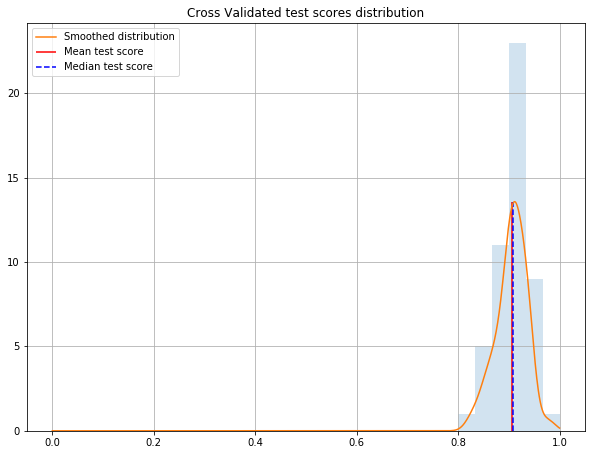

In [26]:
# %load solutions/05B_cross_validation_score_histogram.py
_ = plt.hist(scores, range=(0, 1), bins=30, alpha=0.2)

from scipy.stats.kde import gaussian_kde
x = np.linspace(0, 1, 1000)
smoothed = gaussian_kde(scores).evaluate(x)
plt.plot(x, smoothed, label="Smoothed distribution")

top = np.max(smoothed)
plt.vlines([np.mean(scores)], 0, top, color='r', label="Mean test score")
plt.vlines([np.median(scores)], 0, top, color='b', linestyles='dashed',
           label="Median test score")
plt.legend(loc='best')
_ = plt.title("Cross Validated test scores distribution")


## Model Selection with Grid Search

Cross Validation makes it possible to evaluate the performance of a model class and its hyper parameters on the task at hand.

A natural extension is thus to run CV several times for various values of the parameters so as to find the best. For instance, let's fix the SVC parameter to `C=10` and compute the cross validated test score for various values of `gamma`:

In [27]:
n_gammas = 10
n_iter = 5
cv = ShuffleSplit(n_samples, n_iter=n_iter, train_size=500, test_size=500,
    random_state=0)

train_scores = np.zeros((n_gammas, n_iter))
test_scores = np.zeros((n_gammas, n_iter))
gammas = np.logspace(-7, -1, n_gammas)

for i, gamma in enumerate(gammas):
    for j, (train, test) in enumerate(cv):
        clf = SVC(C=10, gamma=gamma).fit(X[train], y[train])
        train_scores[i, j] = clf.score(X[train], y[train])
        test_scores[i, j] = clf.score(X[test], y[test])

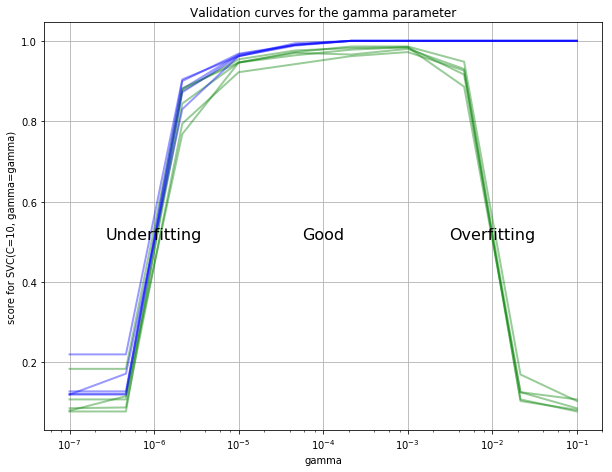

In [28]:
def plot_validation_curves(param_values, train_scores, test_scores):
    for i in range(train_scores.shape[1]):
        plt.semilogx(param_values, train_scores[:, i], alpha=0.4, lw=2, c='b')
        plt.semilogx(param_values, test_scores[:, i], alpha=0.4, lw=2, c='g')

plot_validation_curves(gammas, train_scores, test_scores)
plt.ylabel("score for SVC(C=10, gamma=gamma)")
plt.xlabel("gamma")
plt.text(1e-6, 0.5, "Underfitting", fontsize=16, ha='center', va='bottom')
plt.text(1e-4, 0.5, "Good", fontsize=16, ha='center', va='bottom')
plt.text(1e-2, 0.5, "Overfitting", fontsize=16, ha='center', va='bottom')
plt.title('Validation curves for the gamma parameter');

We can see that, **for this model class, on this unscaled dataset**: when `C=10`, **there is a sweet spot region for gamma around $10^4$ to $10^3$**. Both the train and test scores are high (low errors).

- If **gamma is too low, train score is low** (and thus test scores too as it generally cannot be better than the train score): the model is not expressive enough to represent the data: the model is in an **underfitting regime**.
        
- If **gamma is too high**, train score is ok but there is a high discrepency between test and train score. The model is learning the training data and its noise by heart and fails to generalize to new unseen data: the model is in an **overfitting regime**.

Note: scikit-learn provides tools to compute such curves easily, we can do the same kind analysis to identify good values for C when gamma is fixed to $10^3$:

In [29]:
from sklearn.learning_curve import validation_curve

n_Cs = 10
Cs = np.logspace(-5, 5, n_Cs)

train_scores, test_scores = validation_curve(
    SVC(gamma=1e-3), X, y, 'C', Cs, cv=cv)

/anaconda/envs/python2/lib/python2.7/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


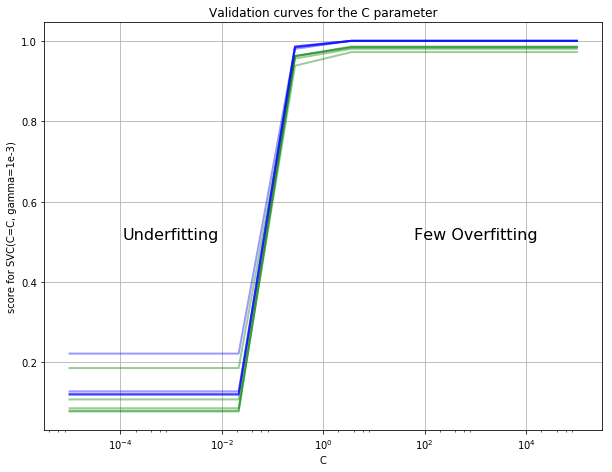

In [30]:
plot_validation_curves(Cs, train_scores, test_scores)
plt.ylabel("score for SVC(C=C, gamma=1e-3)")
plt.xlabel("C")
plt.text(1e-3, 0.5, "Underfitting", fontsize=16, ha='center', va='bottom')
plt.text(1e3, 0.5, "Few Overfitting", fontsize=16, ha='center', va='bottom')
plt.title('Validation curves for the C parameter');

Doing this procedure several for each parameter combination is tedious, hence it's possible to automate the procedure by computing the test score for all possible combinations of parameters using the `GridSearchCV` helper.

In [31]:
from sklearn.grid_search import GridSearchCV
#help(GridSearchCV)

/anaconda/envs/python2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [32]:
from pprint import pprint
svc_params = {
    'C': np.logspace(-1, 2, 4),
    'gamma': np.logspace(-4, 0, 5),
}
pprint(svc_params)

{'C': array([   0.1,    1. ,   10. ,  100. ]),
 'gamma': array([  1.00000000e-04,   1.00000000e-03,   1.00000000e-02,
         1.00000000e-01,   1.00000000e+00])}


As Grid Search is a costly procedure, let's do the some experiments with a smaller dataset:

In [33]:
n_subsamples = 500
X_small_train, y_small_train = X_train[:n_subsamples], y_train[:n_subsamples]

In [34]:
gs_svc = GridSearchCV(SVC(), svc_params, cv=3, n_jobs=-1)

%time _ = gs_svc.fit(X_small_train, y_small_train)

CPU times: user 266 ms, sys: 83.6 ms, total: 349 ms
Wall time: 690 ms


In [35]:
gs_svc.best_params_, gs_svc.best_score_

({'C': 10.0, 'gamma': 0.001}, 0.976)

In [36]:
gs_svc.grid_scores_

[mean: 0.16200, std: 0.02588, params: {'C': 0.10000000000000001, 'gamma': 0.0001},
 mean: 0.71000, std: 0.03978, params: {'C': 0.10000000000000001, 'gamma': 0.001},
 mean: 0.12800, std: 0.00161, params: {'C': 0.10000000000000001, 'gamma': 0.01},
 mean: 0.12800, std: 0.00161, params: {'C': 0.10000000000000001, 'gamma': 0.10000000000000001},
 mean: 0.12800, std: 0.00161, params: {'C': 0.10000000000000001, 'gamma': 1.0},
 mean: 0.93800, std: 0.00586, params: {'C': 1.0, 'gamma': 0.0001},
 mean: 0.96600, std: 0.00295, params: {'C': 1.0, 'gamma': 0.001},
 mean: 0.26600, std: 0.02009, params: {'C': 1.0, 'gamma': 0.01},
 mean: 0.12800, std: 0.00161, params: {'C': 1.0, 'gamma': 0.10000000000000001},
 mean: 0.12800, std: 0.00161, params: {'C': 1.0, 'gamma': 1.0},
 mean: 0.97000, std: 0.00466, params: {'C': 10.0, 'gamma': 0.0001},
 mean: 0.97600, std: 0.00041, params: {'C': 10.0, 'gamma': 0.001},
 mean: 0.32600, std: 0.02186, params: {'C': 10.0, 'gamma': 0.01},
 mean: 0.12800, std: 0.00161, param

In [37]:
first_score = gs_svc.grid_scores_[0]
first_score

mean: 0.16200, std: 0.02588, params: {'C': 0.10000000000000001, 'gamma': 0.0001}

In [38]:
dict(vars(first_score))

{'cv_validation_scores': array([ 0.17647059,  0.1257485 ,  0.18404908]),
 'mean_validation_score': 0.162,
 'parameters': {'C': 0.10000000000000001, 'gamma': 0.0001}}

Let's define a couple of helper function to help us introspect the details of the grid search outcome:

In [39]:
def display_scores(params, scores, append_star=False):
    """Format the mean score +/- std error for params"""
    params = ", ".join("{0}={1}".format(k, v)
                      for k, v in params.items())
    line = "{0}:\t{1:.3f} (+/-{2:.3f})".format(
        params, np.mean(scores), sem(scores))
    if append_star:
        line += " *"
    return line

def display_grid_scores(grid_scores, top=None):
    """Helper function to format a report on a grid of scores"""
    
    grid_scores = sorted(grid_scores, key=lambda x: x[1], reverse=True)
    if top is not None:
        grid_scores = grid_scores[:top]
        
    # Compute a threshold for staring models with overlapping
    # stderr:
    _, best_mean, best_scores = grid_scores[0]
    threshold = best_mean - 2 * sem(best_scores)
    
    for params, mean_score, scores in grid_scores:
        append_star = mean_score + 2 * sem(scores) > threshold
        print(display_scores(params, scores, append_star=append_star))

In [40]:
display_grid_scores(gs_svc.grid_scores_, top=20)

C=10.0, gamma=0.001:	0.976 (+/-0.000) *
C=100.0, gamma=0.001:	0.976 (+/-0.000) *
C=10.0, gamma=0.0001:	0.970 (+/-0.003) *
C=1.0, gamma=0.001:	0.966 (+/-0.002)
C=100.0, gamma=0.0001:	0.960 (+/-0.005)
C=1.0, gamma=0.0001:	0.938 (+/-0.004)
C=0.1, gamma=0.001:	0.711 (+/-0.028)
C=10.0, gamma=0.01:	0.326 (+/-0.015)
C=100.0, gamma=0.01:	0.326 (+/-0.015)
C=1.0, gamma=0.01:	0.266 (+/-0.014)
C=0.1, gamma=0.0001:	0.162 (+/-0.018)
C=0.1, gamma=0.01:	0.128 (+/-0.001)
C=0.1, gamma=0.1:	0.128 (+/-0.001)
C=0.1, gamma=1.0:	0.128 (+/-0.001)
C=1.0, gamma=0.1:	0.128 (+/-0.001)
C=1.0, gamma=1.0:	0.128 (+/-0.001)
C=10.0, gamma=0.1:	0.128 (+/-0.001)
C=10.0, gamma=1.0:	0.128 (+/-0.001)
C=100.0, gamma=0.1:	0.128 (+/-0.001)
C=100.0, gamma=1.0:	0.128 (+/-0.001)


One can see that Support Vector Machine with RBF kernel are very sensitive wrt. the `gamma` parameter (the badwith of the kernel) and to some lesser extend to the `C` parameter as well. If those parameter are not grid searched, the predictive accurracy of the support vector machine is almost no better than random guessing!

By default, the `GridSearchCV` class refits a final model on the complete training set with the best parameters found by during the grid search:

In [41]:
gs_svc.score(X_test, y_test)

0.98666666666666669

Evaluating this final model on the real test set will often yield a better score because of the larger training set, especially when the training set is small and the number of cross validation folds is small (`cv=3` here).

**Exercise**:

1. Find a set of parameters for an `sklearn.tree.DecisionTreeClassifier` on the `X_small_train` / `y_small_train` digits dataset to reach at least 75% accuracy on the sample dataset (500 training samples)
2. In particular you can grid search good values for `criterion`, `min_samples_split` and `max_depth`
3. Which parameter(s) seems to be the most important to tune?
4. Retry with `sklearn.ensemble.ExtraTreesClassifier(n_estimators=30)` which is a randomized ensemble of decision trees. Does the parameters that make the single trees work best also make the ensemble model work best?

Hints:

- If the outcome of the grid search is too instable (overlapping std errors), increase the number of CV folds with `cv` constructor parameter. The default value is `cv=3`. Increasing it to `cv=5` or `cv=10` often yield more stable results but at the price of longer evaluation times.
- Start with a small grid, e.g. 2 values `criterion` and 3 for `min_samples_split` only to avoid having to wait for too long at first.

Type:

    from sklearn.tree.DecisionTreeClassifier
    DecisionTreeClassifier?  # to read the docstring and know the list of important parameters
    print(DecisionTreeClassifier())  # to show the list of default values

    from sklearn.ensemble.ExtraTreesClassifier
    ExtraTreesClassifier? 
    print(ExtraTreesClassifier())

**Solution**:

In [42]:
from sklearn.tree import DecisionTreeClassifier
DecisionTreeClassifier()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [43]:
tree = DecisionTreeClassifier()

tree_params = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 20],
    'max_depth': [5, 7, None],
}

cv = ShuffleSplit(n_subsamples, n_iter=50, test_size=0.1)
gs_tree = GridSearchCV(tree, tree_params, n_jobs=-1, cv=cv)

%time gs_tree.fit(X_train[:n_samples], y_train[:n_samples])
display_grid_scores(gs_tree.grid_scores_)

CPU times: user 1.73 s, sys: 465 ms, total: 2.19 s
Wall time: 2.2 s
min_samples_split=2, criterion=entropy, max_depth=None:	0.804 (+/-0.008) *
min_samples_split=2, criterion=entropy, max_depth=7:	0.802 (+/-0.007) *
min_samples_split=10, criterion=entropy, max_depth=7:	0.797 (+/-0.008) *
min_samples_split=20, criterion=entropy, max_depth=None:	0.789 (+/-0.008) *
min_samples_split=20, criterion=entropy, max_depth=7:	0.782 (+/-0.007) *
min_samples_split=2, criterion=gini, max_depth=7:	0.776 (+/-0.008) *
min_samples_split=2, criterion=gini, max_depth=None:	0.775 (+/-0.009) *
min_samples_split=10, criterion=gini, max_depth=None:	0.774 (+/-0.009) *
min_samples_split=10, criterion=entropy, max_depth=None:	0.771 (+/-0.008)
min_samples_split=10, criterion=gini, max_depth=7:	0.764 (+/-0.008)
min_samples_split=10, criterion=entropy, max_depth=5:	0.758 (+/-0.009)
min_samples_split=20, criterion=gini, max_depth=None:	0.757 (+/-0.009)
min_samples_split=2, criterion=entropy, max_depth=5:	0.755 (+/-0.

As the dataset is quite small and decision trees are prone to overfitting, we need cross validate many times (e.g. `n_iter=50`) to get standard error of the mean test score below `0.010`.

At that level of precision one can observe that the `entropy` split criterion yields slightly better predictions than `gini`. One can also observe that traditional regularization strategies (limiting the depth of the tree or giving a minimum number of samples to allow for a node to split does not work well on this problem.

Indeed, the unregularized decision tree (`max_depth=None` and `min_samples_split=2`) is among the top performers while it is clearly overfitting:

In [44]:
unreg_tree = DecisionTreeClassifier(criterion='entropy', max_depth=None,
                                    min_samples_split=2)
unreg_tree.fit(X_small_train, y_small_train)
print("Train score: %0.3f" % unreg_tree.score(X_small_train, y_small_train))
print("Test score: %0.3f" % unreg_tree.score(X_test, y_test))

Train score: 1.000
Test score: 0.793


Limiting the depth to 7 or setting the minimum number of samples to 20: this regularization add as much bias (hence training error) as it removes variance (as measured by the gap between training and test score) hence does not make it possible to solve the overfitting issue efficiently, for instance:

In [45]:
reg_tree = DecisionTreeClassifier(criterion='entropy', max_depth=7,
                                    min_samples_split=10)
reg_tree.fit(X_small_train, y_small_train)
print("Train score: %0.3f" % reg_tree.score(X_small_train, y_small_train))
print("Test score: %0.3f" % reg_tree.score(X_test, y_test))

Train score: 0.938
Test score: 0.760


From the grid scores results one can also observe that regularizing too much is clearly detrimental: the models with a depth limited to 5 are clearly inferior to those limited to 7 or not depth limited at all (on this dataset).

To combat overfitting, of decision trees, it is preferable to use an ensemble approach that randomize the learning even further and then average the predictions as we will see with the `ExtraTreesClassifier` model class:

In [46]:
from sklearn.ensemble import ExtraTreesClassifier
print(ExtraTreesClassifier())
#ExtraTreesClassifier?

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


In [47]:
trees = ExtraTreesClassifier(n_estimators=30)

cv = ShuffleSplit(n_subsamples, n_iter=5, test_size=0.1)
gs_trees = GridSearchCV(trees, tree_params, n_jobs=-1, cv=cv)

%time gs_trees.fit(X_small_train, y_small_train)
display_grid_scores(gs_trees.grid_scores_)

CPU times: user 658 ms, sys: 111 ms, total: 769 ms
Wall time: 3.38 s
min_samples_split=20, criterion=entropy, max_depth=None:	0.968 (+/-0.015) *
min_samples_split=10, criterion=entropy, max_depth=5:	0.956 (+/-0.015) *
min_samples_split=20, criterion=gini, max_depth=None:	0.952 (+/-0.022) *
min_samples_split=10, criterion=entropy, max_depth=None:	0.948 (+/-0.008) *
min_samples_split=2, criterion=gini, max_depth=None:	0.940 (+/-0.021) *
min_samples_split=2, criterion=entropy, max_depth=7:	0.940 (+/-0.024) *
min_samples_split=2, criterion=gini, max_depth=5:	0.936 (+/-0.021) *
min_samples_split=20, criterion=gini, max_depth=5:	0.936 (+/-0.013) *
min_samples_split=10, criterion=gini, max_depth=None:	0.936 (+/-0.017) *
min_samples_split=10, criterion=entropy, max_depth=7:	0.936 (+/-0.012) *
min_samples_split=2, criterion=entropy, max_depth=None:	0.932 (+/-0.022) *
min_samples_split=10, criterion=gini, max_depth=5:	0.924 (+/-0.017) *
min_samples_split=20, criterion=gini, max_depth=7:	0.924 (+

A couple of remarks:

  - `ExtraTreesClassifier` achieve a much better generalization than individual decistion trees (0.97 vs 0.80) even on such a small dataset so they are indeed able to solve the overfitting issue of individual decision trees.

  - `ExtraTreesClassifier` are much longer to train than individual trees but the fact that the predictions is averaged makes it no necessary to cross validate as many times to reach a stderr on the order of `0.010`.

  - `ExtraTreesClassifier` are very robust to the choice of the parameters: most grid search point achieve a good prediction (even when higly regularized) although too much regularization is harmful. We can also note that the split criterion is no longer relevant.

Finally one can also observe that despite the high level of randomization of the individual trees, an ensemble model composed of unregularized trees is not underfitting:

In [48]:
unreg_trees = ExtraTreesClassifier(n_estimators=50, max_depth=None, min_samples_split=2)
unreg_trees.fit(X_small_train, y_small_train)
print("Train score: %0.3f" % unreg_trees.score(X_small_train, y_small_train))
print("Test score: %0.3f" % unreg_trees.score(X_test, y_test))

Train score: 1.000
Test score: 0.956


More interesting, an ensemble model composed of regularized trees is not underfitting much less than the individual regularized trees:

In [49]:
reg_trees = ExtraTreesClassifier(n_estimators=50, max_depth=7, min_samples_split=10)
reg_trees.fit(X_small_train, y_small_train)
print("Train score: %0.3f" % reg_trees.score(X_small_train, y_small_train))
print("Test score: %0.3f" % reg_trees.score(X_test, y_test))

Train score: 1.000
Test score: 0.940


## Plotting Learning Curves for Bias-Variance analysis

In order to better understand the behavior of model (model class + contructor parameters), is it possible to run several cross validation steps for various random sub-samples of the training set and then plot the mean training and test errors.

These plots are called the **learning curves**.

sklearn does not yet provide turn-key utilities to plot such learning curves but is not very complicated to compute them by leveraging the `ShuffleSplit` class. First let's define a range of data set sizes for subsampling the training set:

In [50]:
train_sizes = np.logspace(2, 3, 5).astype(np.int)
train_sizes

array([ 100,  177,  316,  562, 1000])

For each training set sizes we will compute `n_iter` cross validation iterations. Let's pre-allocate the arrays to store the results:

In [51]:
n_iter = 20
train_scores = np.zeros((train_sizes.shape[0], n_iter), dtype=np.float)
test_scores = np.zeros((train_sizes.shape[0], n_iter), dtype=np.float)

We can now loop over training set sizes and CV iterations:

In [52]:
svc = SVC(C=1, gamma=0.0005)

for i, train_size in enumerate(train_sizes):
    cv = ShuffleSplit(n_samples, n_iter=n_iter, train_size=train_size)
    for j, (train, test) in enumerate(cv):
        svc.fit(X[train], y[train])
        train_scores[i, j] = svc.score(X[train], y[train])
        test_scores[i, j] = svc.score(X[test], y[test])

We can now plot the mean scores with error bars that reflect the standard errors of the means:

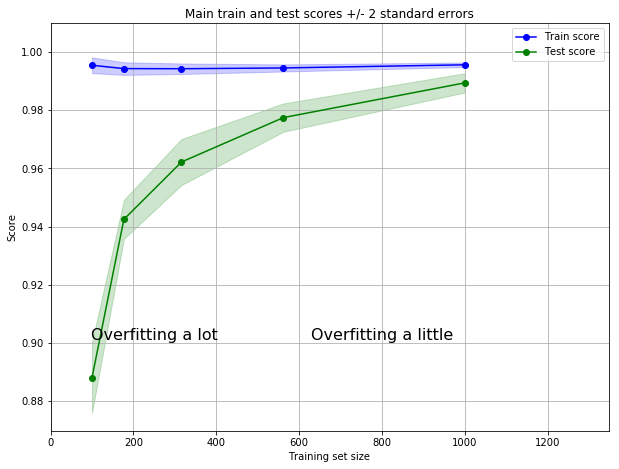

In [53]:
mean_train = np.mean(train_scores, axis=1)
confidence = sem(train_scores, axis=1) * 2

plt.fill_between(train_sizes,
                 mean_train - confidence,
                 mean_train + confidence,
                 color = 'b', alpha = .2)
plt.plot(train_sizes, mean_train, 'o-k', c='b', label='Train score')

mean_test = np.mean(test_scores, axis=1)
confidence = sem(test_scores, axis=1) * 2

plt.fill_between(train_sizes,
                 mean_test - confidence,
                 mean_test + confidence,
                 color = 'g', alpha = .2)
plt.plot(train_sizes, mean_test, 'o-k', c='g', label='Test score')

plt.xlabel('Training set size')
plt.ylabel('Score')
plt.xlim(0, X_train.shape[0])
plt.ylim((None, 1.01))  # The best possible score is 1.0
plt.legend(loc='best')

plt.text(250, 0.9, "Overfitting a lot", fontsize=16, ha='center', va='bottom')
plt.text(800, 0.9, "Overfitting a little", fontsize=16, ha='center', va='bottom')
plt.title('Main train and test scores +/- 2 standard errors');

Note: learning curves can be computed with there own utility function:

In [54]:
from sklearn.learning_curve import learning_curve

## Interpreting Learning Curves

- If the **training set error is high** (e.g. more than 5% misclassification) at the end of the learning curve, the model suffers from **high bias** and is said to **underfit** the training set.

- If the **testing set error is significantly larger than the training set error**, the model suffers from **high variance** and is said to **overfit** the training set.

Another possible source of high training and testing error is label noise: the data is too noisy and there is nothing few signal learn from it.

### What to do against overfitting?

- Try to get rid of noisy features using **feature selection** methods (or better let the model do it if the regularization is able to do so: for instance l1 penalized linear models)
- Try to tune parameters to add **more regularization**:
    - Smaller values of `C` for SVM
    - Larger values of `alpha` for penalized linear models
    - Restrict to shallower trees (decision stumps) and lower numbers of samples per leafs for tree-based models
- Try **simpler model families** such as penalized linear models (e.g. Linear SVM, Logistic Regression, Naive Bayes)
- Try the ensemble strategies that **average several independently trained models** (e.g. bagging or blending ensembles): average the predictions of independently trained models
- Collect more **labeled samples** if the learning curves of the test score has a non-zero slope on the right hand side.

### What to do against underfitting?

- Give **more freedom** to the model by relaxing some parameters that act as regularizers:
    - Larger values of `C` for SVM
    - Smaller values of `alpha` for penalized linear models
    - Allow deeper trees and lower numbers of samples per leafs for tree-based models
- Try **more complex / expressive model families**:
    - Non linear kernel SVMs,
    - Ensemble of Decision Trees...
- **Construct new features**:
    - bi-gram frequencies for text classifications
    - feature cross-products (possibly using the hashing trick)
    - unsupervised features extraction (e.g. triangle k-means, auto-encoders...)
    - non-linear kernel approximations + linear SVM instead of simple linear SVM

## Final Model Assessment

Grid Search parameters tuning can it-self be considered a (meta-)learning algorithm. Hence there is a risk of not taking into account the **overfitting of the grid search procedure** it-self.

To quantify and mitigate this risk we can nest the train / test split concept one level up:
    
Maker a top level "Development / Evaluation" sets split:
    
- Development set used for Grid Search and training of the model with optimal parameter set
- Hold out evaluation set used **only** for estimating the predictive performance of the resulting model

For dataset sampled over time, it is **highly recommended to use a temporal split** for the Development / Evaluation split: for instance, if you have collected data over the 2008-2013 period, you can:
    
- use 2008-2011 for development (grid search optimal parameters and model class),
- 2012-2013 for evaluation (compute the test score of the best model parameters).

## One Final Note About kernel SVM Parameters Tuning

In this session we applied the SVC model with RBF kernel on unormalized features: this is bad! If we had used a normalizer, the default parameters for `C` and `gamma` of SVC would directly have led to close to optimal performance:

In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = SVC().fit(X_train_scaled, y_train)  # Look Ma'! Default params!
print("Train score: {0:.3f}".format(clf.score(X_train_scaled, y_train)))
print("Test score: {0:.3f}".format(clf.score(X_test_scaled, y_test)))

Train score: 0.996
Test score: 0.984


This is because once normalized, the digits is very regular and fits the assumptions of the default parameters of the `SVC` class very well. This is rarely the case though and usually it's always necessary to grid search the parameters.

Nonetheless, **scaling should be a mandatory preprocessing step when using SVC, especially with a RBF kernel**.